# Introduction
Founded in 1997, MovieLens is a website and online community that generates movie recommendations for users via collaborative filtering.  Users begin by creating an account and rating some number of movies they have previously watched on a scale of 0.5 stars to 5 stars. MovieLens's recommendation algorithm then uses the user's ratings, as well as other users' rating patterns, to generate movie recommendations for the user. As the user rates more movies over time, the recommendations change in real time, becoming more personalized (and thus theoretically more successful) over time.

MovieLens makes its datasets, consisting of some 20 million ratings covering over 27,000 movies, available to the public.  These datasets include the numerical rating and the associated user ID, movie ID, and date and time of rating.  For this study, we'll look at two datasets: a up-to-date random sample of 100K ratings, and a full dataset of 20 million ratings.  For ease of use, we'll begin with an exploratory look at the smaller 100K sample.  Later on, we'll run significance tests and use the larger dataset as necessary. 

# Loading the Data

The function load_and_clean imports the specified datasets, reformats dates, and merges the ratings data with the movies data.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline

In [2]:
# load small data
from load_and_clean import load_and_clean
smallRatings_df = load_and_clean("ml-latest-small/movies.csv", "ml-latest-small/ratings.csv")
smallRatings_df.head()

,userId,movieId,rating,title,genres,datetime,date,month,weekday
0,1,31,2.5,Dangerous Minds (1995),Drama,2009-12-14 02:52:24,2009-12-14,12,0
1,7,31,3.0,Dangerous Minds (1995),Drama,1996-12-29 14:12:30,1996-12-29,12,6
2,31,31,4.0,Dangerous Minds (1995),Drama,2010-05-11 01:39:13,2010-05-11,5,1
3,32,31,4.0,Dangerous Minds (1995),Drama,1996-06-15 08:47:20,1996-06-15,6,5
4,36,31,3.0,Dangerous Minds (1995),Drama,1996-11-03 21:40:02,1996-11-03,11,6


# Exploring the Data

Looking at the distribution of scores, two features stand out.  First, although the site allows half-star ratings (0.5, 1.5, etc), users give whole-star ratings (1.0, 2.0, etc) much more often.  This accounts for the dips in the half-star values of the plot on the upper left.  If we round all the ratings up to the nearest full star as in the plot on the upper right plot, we can see the shape of the distribution more clearly.  As the bottom plot shows, the distribution is roughly Gaussian with a leftward skew.

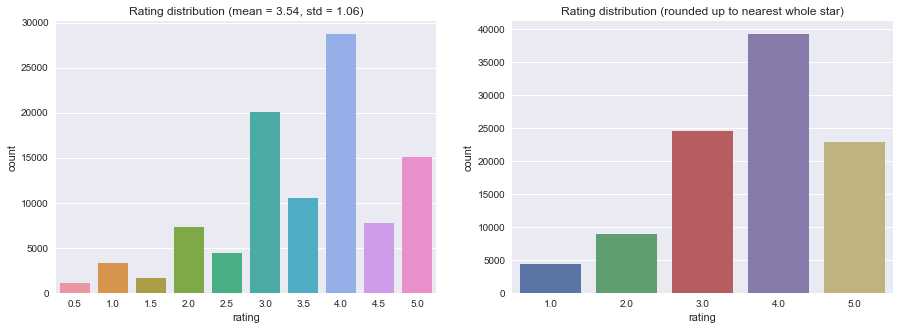

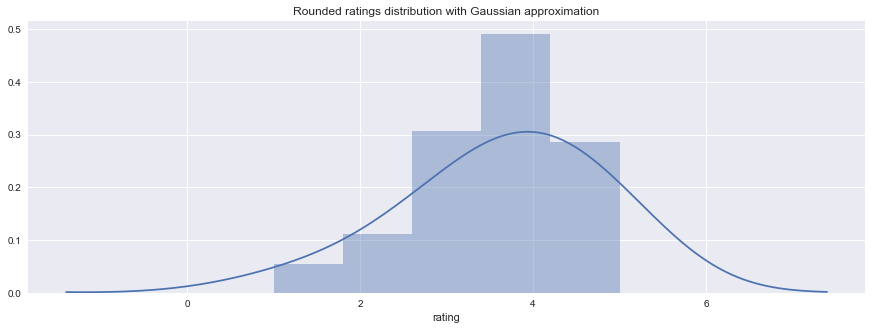

In [3]:
rating_mean = smallRatings_df["rating"].mean()
rating_std = smallRatings_df["rating"].std()

plt.figure(figsize=(15,5))

plt.subplot(121)
sns.countplot("rating", data=smallRatings_df)
plt.title("Rating distribution (mean = {}, std = {})".format(round(rating_mean, 2), round(rating_std, 2)))

plt.subplot(122)
roundedRatings = (smallRatings_df["rating"] + .01).round() # add .01 to avoid skew from default banker's rounding
sns.countplot(roundedRatings)
plt.title("Rating distribution (rounded up to nearest whole star)")
plt.show()

plt.figure(figsize=(15,5))
sns.distplot(roundedRatings, bins=5, kde_kws={'bw':.8})
plt.title("Rounded ratings distribution with Gaussian approximation")
plt.show()

The plots below show the total number of ratings submitted on particular months of the year, days of the week, and years since 1996.  There are ready-to-hand intuitive explanations for some of the differences exhibited here.  For instance, while the data doesn't prove causality, the significant differences across months do correlate with U.S. cultural patterns.  November and December feature significant holiday vacation time for many jobs, but also short daylight and cold weather in many regions.  We would expect this combination to increase indoor leisure time, which could include both movie-watching and movie-rating.  The vacation-heavy summer months are also slightly elevated.  The only result that doesn't have an obvious corollary in U.S. work cycles is the spike in May.

For weekdays, it's unsurprising that the evenings most commonly used for social gatherings (Wednesday, Friday, and Saturday) feature lower movie-rating totals.  People are more likely to be at home and on their computers on these nights.  As for the yearly distribution, given the irregularity of the pattern and the rarity of multi-year institutional cycles in our culture, there are no clearly significant trends.

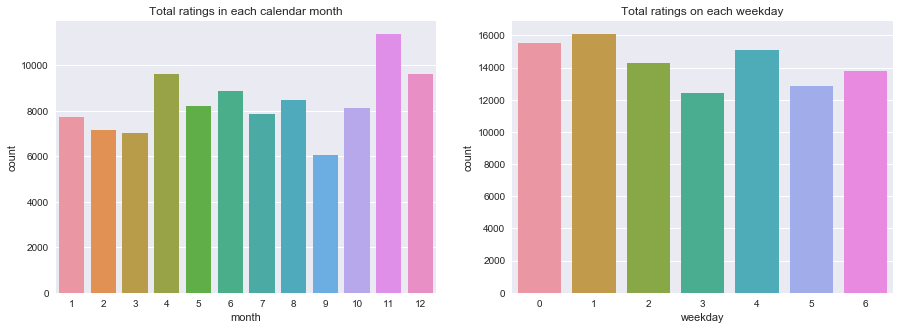

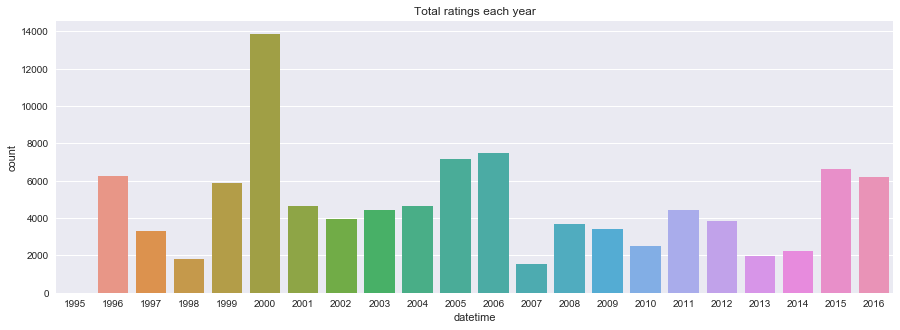

In [4]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.countplot("month", data=smallRatings_df)
plt.title("Total ratings in each calendar month")

plt.subplot(122)
sns.countplot("weekday", data=smallRatings_df)
plt.title("Total ratings on each weekday")
plt.show()

plt.figure(figsize=(15,5))
sns.countplot(smallRatings_df["datetime"].dt.year)
plt.title("Total ratings each year")
plt.show()


As we can see below, the distribution of how many ratings each user submitted is roughly geometric.  The median number of ratings for a single user is 71 (the mean, heavily distorted by outliers, rises to 149).

149.03725782414307


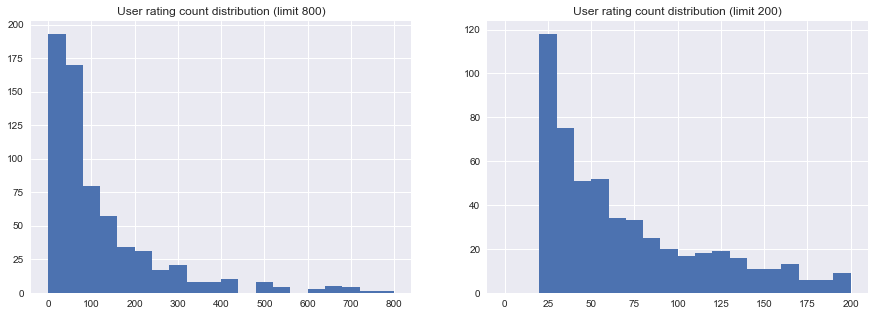

In [5]:
user_df = smallRatings_df.groupby("userId").agg({"movieId":"count", "rating":"mean"})
user_df.rename(index=str, columns={"movieId":"rating_count"}, inplace=True)

plt.figure(figsize=(15,5))
plt.subplot(121)
user_df["rating_count"].hist(range=(0,800), bins=20)
plt.title("User rating count distribution (limit 800)")

plt.subplot(122)
user_df["rating_count"].hist(range=(0,200), bins=20)
plt.title("User rating count distribution (limit 200)")
print(user_df["rating_count"].mean())
plt.show()

# Central Question
One difficulty in assessing the ratings in this dataset is that participants give ratings at different time intervals from their actual viewing.  Some ratings represent ratings for a movie that the user watched just an hour beforehand and remembers in great detail, while others represent ratings for movies that the user watched many years beforehand and retains only a vague impression of.  Given the effects of memory over time, shifts in taste, and intervening life experiences, these ratings may be measuring very different attributes of the viewer-movie interaction.  Interpreting them as equivalent may lead to faulty conclusions and miss valuable insights.

We can roughly encapsulate these considerations in a single question: how do users' ratings of recently watched movies (say, within the past week) differ from their ratings of movies they watched long ago?

# Hypothesis
My hypothesis is that ratings not given recently after watching a movie will tend to regress to the average in users' minds, leading to a smaller degree of dispersion among ratings.  Concretely, my hypothesis is that the standard distribution will be lower for movies not rated recently after watching than for movies rated recently.

It will also be interesting to examine the mean. My secondary hypothesis is that the mean rating will be slightly lower for movies not rated recently after watching than for movies rated recently.

# Methodology
On the face of it, it seems difficult to answer this question based on the available data.  Because MovieLens does not ask the user how long ago or on what date they watched the movie (rating a movie is a one-click process), we don't have any direct time interval data.  However, we can make some inferences based on usage patterns.  Broadly, we can posit three typical usage patterns for rating movies:
<ol>
    <li><b>Profile-building:</b> the user rates multiple movies she has watched at some point - not necessarily recently - in order to generate initial recommendations. (Includes the initial site visit.)</li>
    <li><b>Targeted rating:</b> the user logs in specifically to rate one or more movies she has recently watched</li>
    <li><b>Hybrid rating:</b> the user logs in specifically to rate one or more movies she has recently watched, and then also rates one or more non-recently-watched movies while online.</li>
</ol>
Notably, none of these typical patterns include going online just to rate a single movie that the user watched long ago - it's hard to imagine what motive would prompt that behavior.  This is crucial, because it means that we can distinguish recent vs non-recent ratings based on how many movies the user rated that day.  Specifically, for the purposes of answering our question, we will divide the data into three groups:
<ul>
    <li><b>Singleton ratings:</b> ratings given on days on which that user recorded no other ratings</li>
    <li><b>Small-batch ratings:</b> ratings given on days on which that user recorded two to five ratings</li>
    <li><b>Large-batch ratings:</b> ratings given on days on which that user recorded multiple other ratings</li>
</ul>

We will discard the small-batch ratings as ambiguous, since these could plausibly represent several recently watched movies (usage pattern 2), several non-recently-watched movies (usage pattern 1), or a mixture of the two (usage pattern 3). We will compare the singleton ratings, which almost exclusively represent recently watched movies, against the large-batch ratings, which predominantly represent movies watched less recently than one week.

For each of these sets – the singleton ratings and the large-batch ratings – we will take the mean and the standard deviation.  As they are on the same scale, we do not need to normalize.  We will compare these metrics and run either z-tests or z-tests, depending on the size of these sets, to determine whether these differences are significant, defined as a p value of less than 5%.

Given the large size of the dataset (20 million ratings), it would make good pragmatic sense to begin with evaluating a smaller random subset of 100,000 ratings, which we will divide into singleton, small-batch, and large-batch ratings.  If the p values produced from these subsets are close to or greater than 5%, we will run the tests again on the entire dataset.

# Conclusions and applications
This test will be successful if it demonstrates a significant difference between the singleton and large-batch rating datasets – in either direction.  Even if that difference is the opposite of the hypothesized difference, the test will have produced interesting and useful information about the dataset. The lower the p-value of the difference is, the more significant the result is.  Knowing the nature of this difference will allow us to take recency of rating into account as we analyze the dataset for recommendation algorithm optimization and other purposes.

On the other hand, if there are no significant differences between the two rating sets, this means that one of the premises of the experiment was misguided: either the singletons vs large-batch ratings do not predominantly represent recent vs non-recent ratings (respectively) as supposed, or recent vs non-recent ratings do not actually display any statistically significant differences.

The main application of this study would be toward improving the recommendation algorithm.  A simple approach to movie recommendations would treat all ratings given by a user equally.  The results of this experiment, however, may give us both reason and means to normalize ratings for recency.  Significant differences between recent and non-recent ratings would also give us additional justification to weight ratings according to recency (with batch size and various aspects of individual user patterns serving as proxies for recency).  

Specifically, an optimal recommendation algorithm will likely attach more weight to recent movies.  For one thing, the accuracy and detail of a memory diminish over time.  But equally important is the consideration that individual taste is a moving target for every individual over time.  This means that even a perfect memory of how much a user enjoyed a movie five years ago will be a very imperfect indicator of how much they would like a similar movie today. How much the user enjoyed a movie five hours ago, while still subject to a host of variable factors, will be more reliable. 

If this line of reasoning in favor of recent ratings is correct, the datasets of recent vs non-recent ratings will show differences in their distribution.  The experiment outlined here would not be sufficient to prove that a recency-weighted algorithm will be more effective, but it would lend evidential support to such an argument.


# Further research
A reasonable next step in investigating and using the results of this study would be to build a recommendation algorithm that uses recency-based weighting and normalization. This new algorithm could then be tested against the original algorithm on MovieLens.  Provided an adequate number of users to establish significance, a simple A/B test would be adequate; if the number of regular users is smaller, we could randomize the recommendation algorithm for each login or page reload rather than each user.  Success would be based on the average subsequent user rating of recommended movies.

While A/B testing could confirm these results and give us new data, there are also ways we could dig further into the data we have.  Specifically, we could perform further study of recency differentials (the gap between recenct and non-recent ratings).  Looking at recency differentials for different users could help us categorize different types of viewers by recency effects.  Perhaps more practically, looking at recency differentials for different movies may help us determine which types of movies age positively vs negatively in viewers' memories over time.  This could help generate re-watch recommendations, or predict demand for DVD sales and other post-release merchandizing.

# Bonus: basic execution
From the basic execution below, we can see that the mean values and standard distributions of the singleton vs. large-batch ratings differ slightly, but significantly (p = 0.00000000049).  Both my primary and secondary hypothesis (that singleton ratings would have a higher average and a higher standard deviation) turned out to be false.  But given the  p-value, the experiment was still successful in producing significant information.

The plots below also reveal another significant difference: singleton ratings are much more likely to utilize half-star ratings (0.5, etc).  This supports (but does not prove) the assumption that singleton ratings are for recent movies, which are remembered in much greater detail.

The next step in this experiment, before pursuing the further research options listed above, would be to try toggling the threshholds between singleton, small-batch, and large-batch ratings and seeing how that affects these basic results.

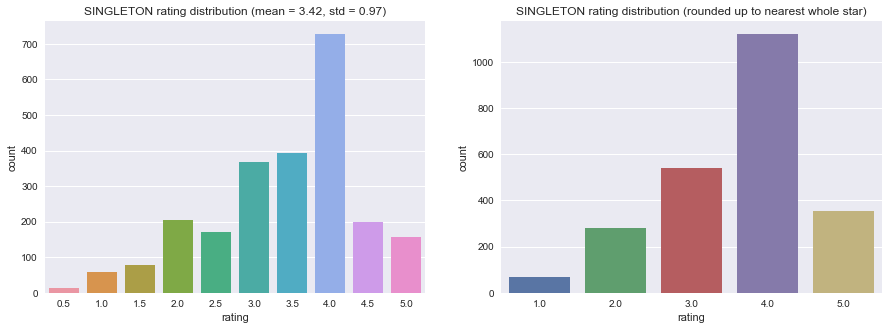

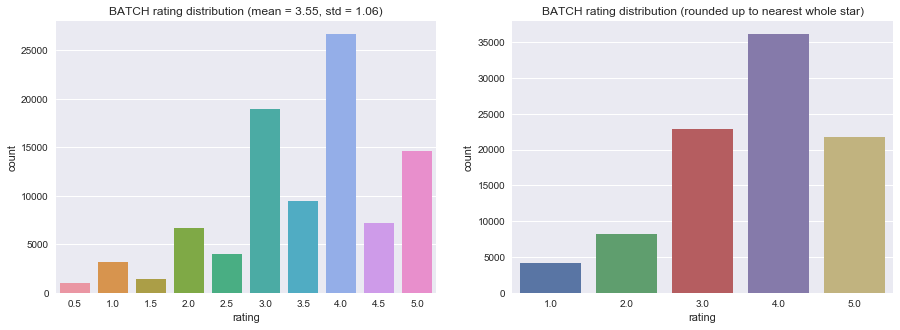

P-value for singleton vs. large-batch ratings: 4.900804311250795e-10


In [8]:
from experiment import split, contrastPlots

singletons_df, batches_df = split(smallRatings_df)
contrastPlots(singletons_df, batches_df)

p_val = sp.stats.ttest_ind(singletons_df["rating"], batches_df["rating"])[1]
print("P-value for singleton vs. large-batch ratings: {}".format(p_val))
